# Classification with standard parameters

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
import matplotlib as mpl
import os

# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Voting Classifiers

### Load data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513


### Drop not important features

In [3]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009


### Split into train/test sets

In [4]:
X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Ensemble learning

In [5]:
# Xgboost parameters
xgb_params = {'learning_rate': 0.05,
              'max_depth': 4,
              'subsample': 0.9,
              'colsample_bytree': 0.9,
              'objective': 'binary:logistic',
              'silent': 1,
              'n_estimators': 100,
              'gamma': 1,
              'min_child_weight': 4,
              # ENABLE GPU COMPUTING BY UNCOMMENTING BELOW
              # 'gpu_id': 0,
              # 'tree_method': 'gpu_hist'
              }
xgb_clf = XGBClassifier(**xgb_params, seed=10)
log_clf = LogisticRegression(
    solver="liblinear", random_state=42, multi_class='auto')
rnd_clf = RandomForestClassifier(n_estimators=3, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)
knn_clf = KNeighborsClassifier()
sgd_clf = SGDClassifier(max_iter=500, tol=-np.infty, random_state=42)
lsvm_clf = LinearSVC(C=10, loss="hinge", max_iter=10000, random_state=42)
rbf_svm_clf = SVC(kernel="rbf", gamma=0.1, C=1000)
nusvm_clf = NuSVC(gamma='scale')
poly_svm_clf = SVC(kernel="poly", gamma="scale",degree=3, coef0=100, C=5)
tree_clf = DecisionTreeClassifier(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf),
                ('lr', log_clf),
                ('rf', rnd_clf),
                ('svc', svm_clf),
                ('tree_clf', tree_clf),
                ('lin_svm', lsvm_clf),
                ('rbf_svm', rbf_svm_clf),
                ('poly_svm', poly_svm_clf),
                ('knn', knn_clf)],
    voting='hard')

### Accuracy Scores for voting ensemble classifier (Hard voting)

In [6]:
# With scaled sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

clf_list = [
    xgb_clf, log_clf, rnd_clf, svm_clf, knn_clf, tree_clf, lsvm_clf,
    poly_svm_clf, voting_clf
]
classifs = [
    'xgb_clf', 'log_clf', 'rnd_clf', 'svm_clf', 'knn_clf', 'tree_clf',
    'lsvm_clf', 'poly_svm_clf', 'voting_clf'
]

for item in zip(classifs, clf_list):
    item[1].fit(X_train_scaled, y_train)
    y_pred = item[1].predict(X_test_scaled)
    print(item[0], accuracy_score(y_test, y_pred))

xgb_clf 0.986
log_clf 0.9432
rnd_clf 0.9772
svm_clf 0.9464
knn_clf 0.8968
tree_clf 0.9816


/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


lsvm_clf 0.9576
poly_svm_clf 0.9852


/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


voting_clf 0.9804


In [7]:
# Without scalint the sets
for item in zip(classifs, clf_list):
    item[1].fit(X_train, y_train)
    y_pred = item[1].predict(X_test)
    print(item[0], accuracy_score(y_test, y_pred))

xgb_clf 0.9932
log_clf 0.9396
rnd_clf 0.986
svm_clf 0.8208
knn_clf 0.7716
tree_clf 0.9824


/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


lsvm_clf 0.948
poly_svm_clf 0.982


/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


voting_clf 0.9776


### CrossVal Scores without standardization

In [14]:
classifs = ['xgb_clf', 'log_clf', 'rnd_clf',
            'svm_clf', 'knn_clf', 'voting_clf']

def cv_learn(classificator_list, X_train, y_train, X_test, y_test,
             cv_size=5, scoring_type="accuracy", average_type="micro"):
    scores = []
    predictions = []
    matrices = []
    reports = []
        
    for clf in (classificator_list):
        # 5xCV
        y_scores = cross_val_score(clf, X_train, y_train,
                                      cv=cv_size, scoring=scoring_type)
        scores.append(y_scores)
        
        # Test Prediction
        pred = cross_val_predict(clf, X_test, y_test, cv=cv_size)
        predictions.append(pred)
        
        # Conf. Matrix
        matrices.append(confusion_matrix(y_test, pred))
        
        # CLF. Report
        reports.append(classification_report(y_test, pred))
        
    return (scores, predictions, matrices, reports)

In [15]:
scores, predictions, matrices, reports = cv_learn(
    clf_list, X_train, y_train, X_test, y_test)

/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed

xgb_clf
[0.98800799 0.98467688 0.99066667 0.98865911 0.993996  ]
Accuracy: 0.989 (+/- 0.006)
xgb_clf :
 [[1230    8    8]
 [  11  231    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



log_clf
[0.93604264 0.93537642 0.958      0.94062708 0.93929286]
Accuracy: 0.942 (+/- 0.017)
log_clf :
 [[1109    1  136]
 [  26  215    1]
 [  49    0  963]]
              precision    recall  f1-score   support

      GALAXY       0.94      0.89      0.91      1246
         QSO       1.00      0.89      0.94       242
        STAR       0.88      0.95      0.91      1012

   micro avg       0.91      0.91      0.91      2500
   macro avg       0.94    

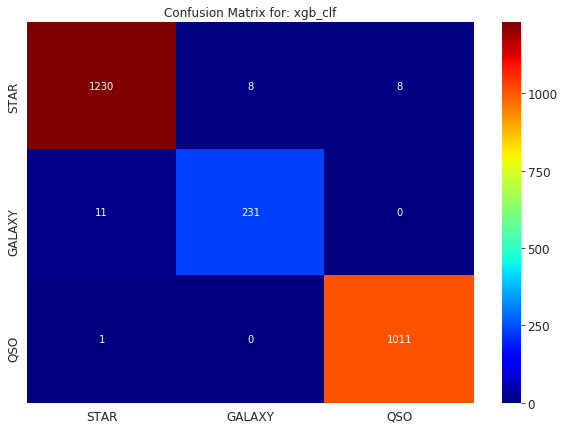

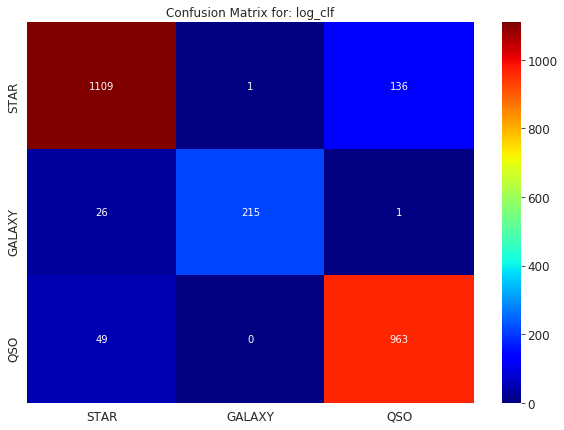

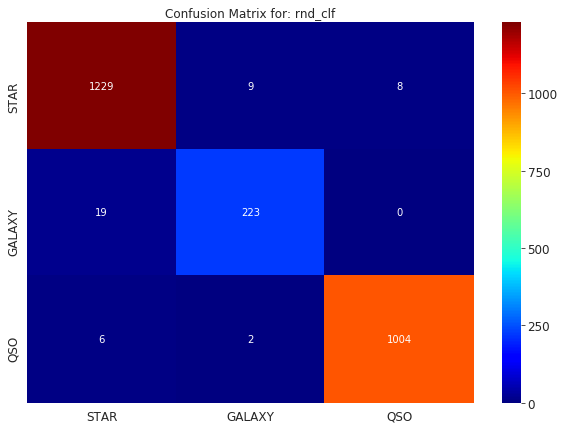

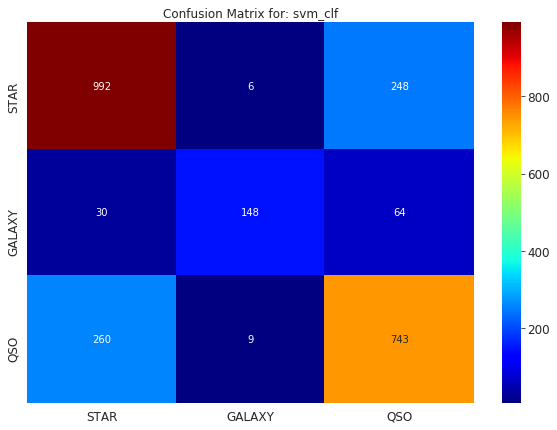

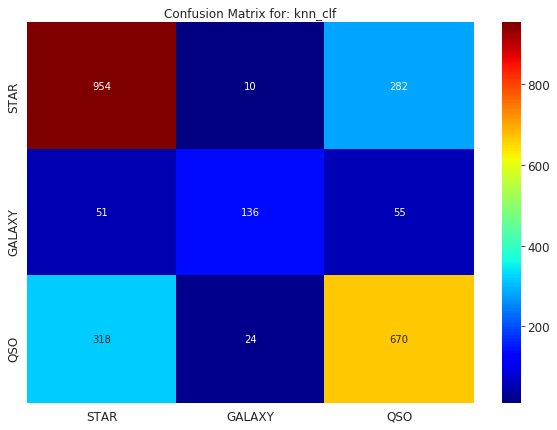

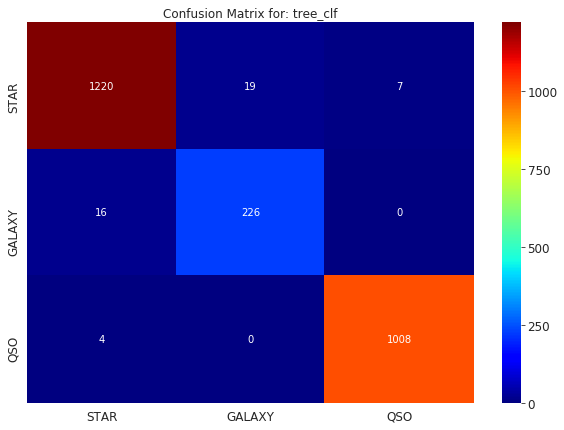

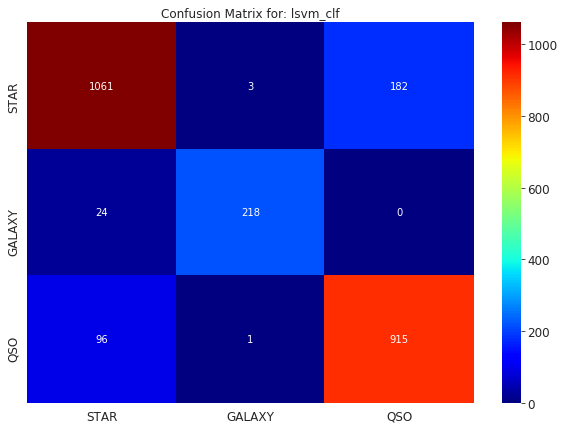

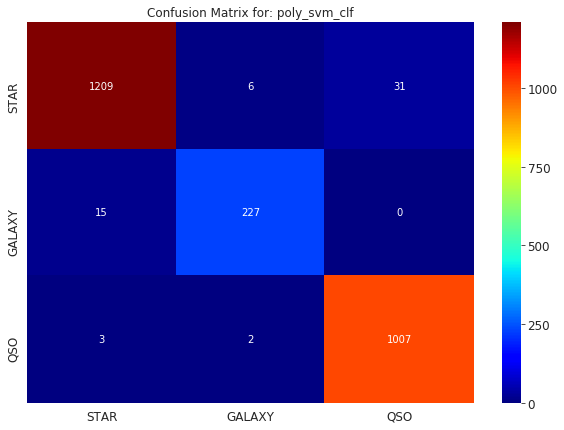

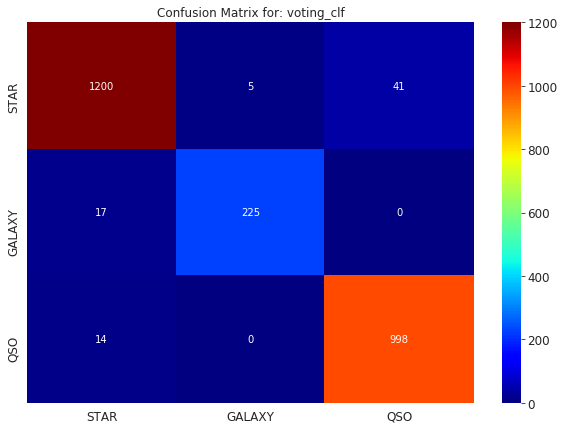

In [16]:
def print_cv_scores(scores):
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))


def print_conf_matrix(clf_name, matrix):
    print(clf_name, ":\n", matrix)


def plot_confusion_matrix(clf_name, class_names, cm, figsize):
    df_cm = pd.DataFrame(cm, index=[i for i in class_names],
                         columns=[i for i in class_names])
    plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="jet").set_title(
        "Confusion Matrix for: " + str(clf_name))

def print_learning_results(classifs, class_names, scores, matrices, reports):
    for item in zip(classifs, scores, matrices, reports):
        print(item[0])
        print(item[1])
        print_cv_scores(item[1])
        print_conf_matrix(item[0], item[2])
        # Plot non-normalized confusion matrix
        plot_confusion_matrix(item[0], class_names, item[2], (10, 7))
        print(item[3])
        print("\n")

class_names = sdss_data["class"].unique()
        
print_learning_results(classifs, class_names, scores, matrices, reports)

### CrossVal Scores with standardization 

In [17]:
scores_scaled, predictions_scaled, matrices_scaled, reports_scaled = cv_learn(
    clf_list, X_train_scaled, y_train, X_test_scaled, y_test)

/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fell/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed

xgb_clf
[0.98800799 0.98467688 0.99066667 0.98865911 0.993996  ]
Accuracy: 0.989 (+/- 0.006)
xgb_clf :
 [[1230    8    8]
 [  11  231    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



log_clf
[0.94470353 0.94603598 0.96066667 0.95263509 0.94796531]
Accuracy: 0.950 (+/- 0.012)
log_clf :
 [[1128    3  115]
 [  25  217    0]
 [  34    0  978]]
              precision    recall  f1-score   support

      GALAXY       0.95      0.91      0.93      1246
         QSO       0.99      0.90      0.94       242
        STAR       0.89      0.97      0.93      1012

   micro avg       0.93      0.93      0.93      2500
   macro avg       0.94    

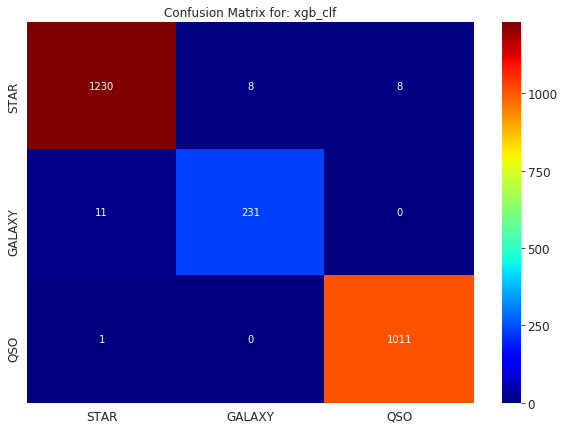

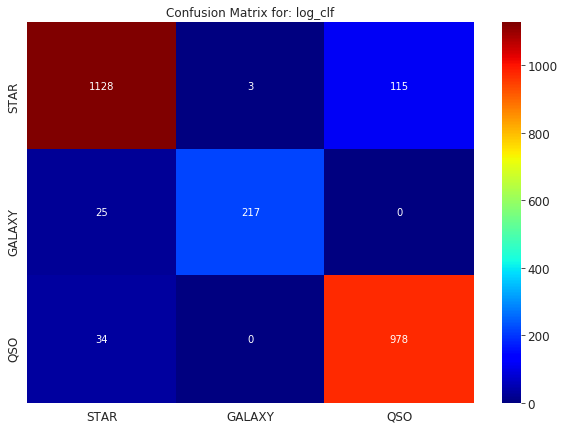

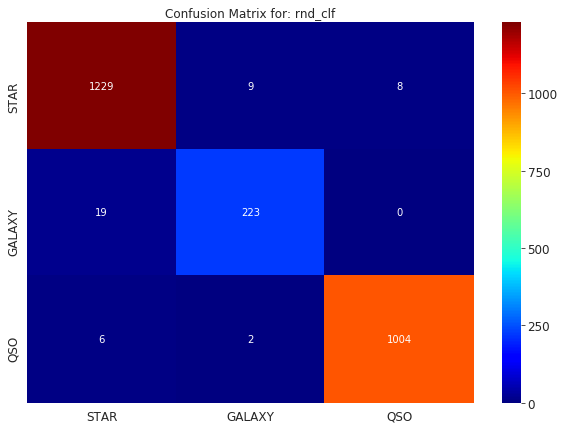

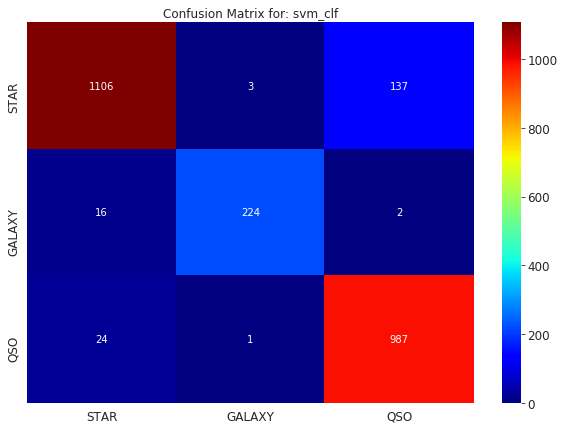

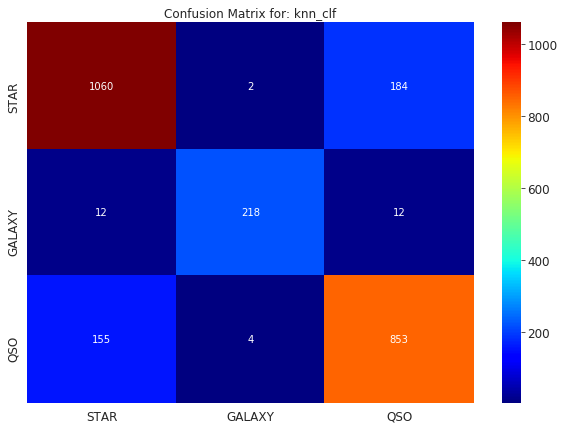

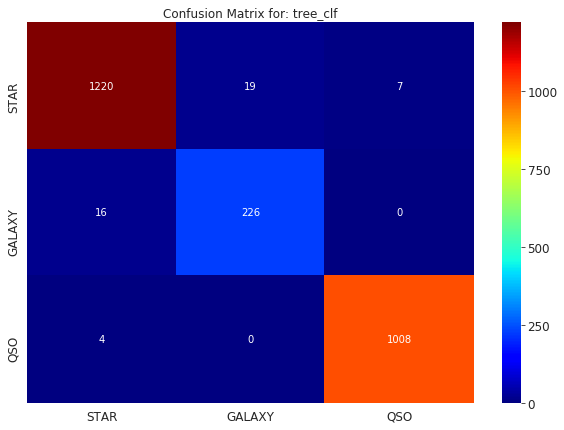

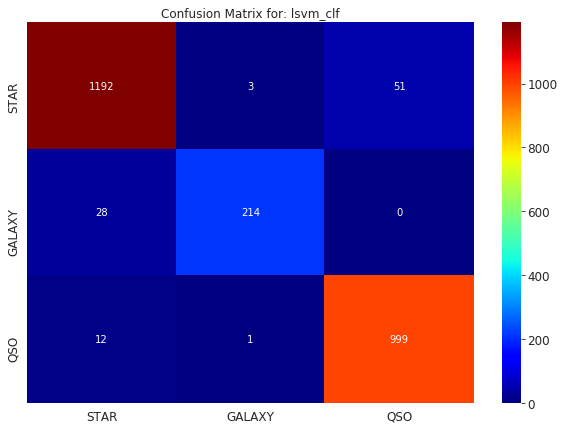

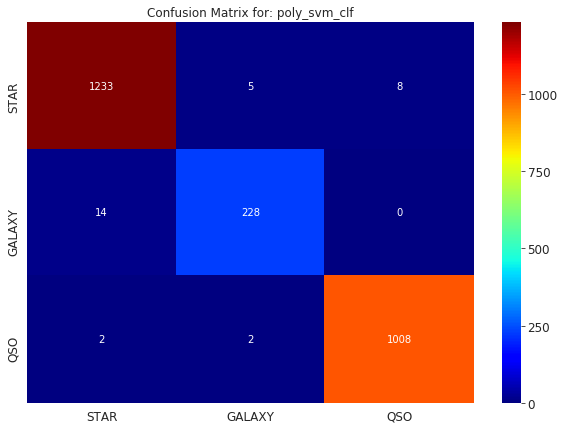

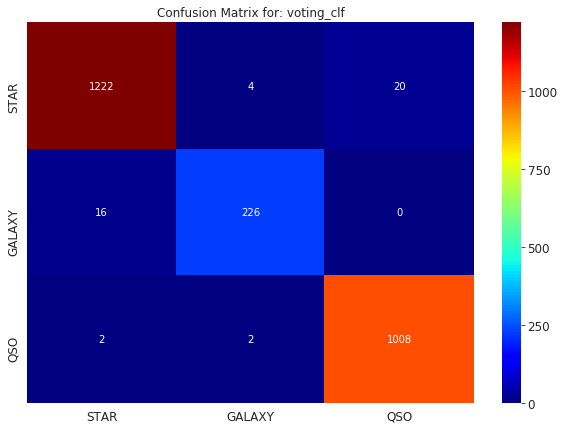

In [18]:
print_learning_results(classifs, class_names, scores_scaled, matrices_scaled, reports_scaled)